# Kv 4.3 Kinetic Scheme for the S390N mutated

## Luca Sagresti

## 07/01/2020

In [1]:
%clear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline

mpl.rcParams['figure.dpi']=100
mpl.rcParams['figure.titlesize']=20
mpl.rcParams['axes.facecolor']='white'        
mpl.rcParams['lines.linewidth']=2.0
mpl.rcParams['axes.linewidth']=2.0
mpl.rcParams['xtick.major.pad']=6
mpl.rcParams['ytick.major.pad']=6
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['axes.titlesize']=18
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['axes.grid']='True'
mpl.rcParams['axes.axisbelow']='line'
mpl.rcParams['legend.fontsize']=12

In [2]:
import pandas as pd

folder="~/PHD/NOTEBOOK/Data_exp_Kv/"

# Activation dataset

dataset_act = pd.read_csv(folder+"Act_datasets.csv", skiprows=1)

act_data = dataset_act.to_numpy()

act_data_WT = act_data[:,1]

act_data_S390N = act_data[:,3]

# Inactivation dataset

dataset_inact = pd.read_csv(folder+"Inact_datasets.csv", skiprows=1)

inact_data = dataset_inact.to_numpy()

inact_data_WT = inact_data[:,1]

inact_data_S390N = inact_data[:,3]

# Recovery dataset

dataset_rec = pd.read_csv(folder+"Rec_datasets.csv", skiprows=1)

rec_data = dataset_rec.to_numpy()

rec_data_WT = rec_data[:,1]

rec_data_S390N = rec_data[:,3]

## Activation Model for the Mutated

In [227]:
def ode_act_mut (C, t, p):
    
    C0=C[0]
    C1=C[1]
    C2=C[2]
    C3=C[3]
    C4=C[4]
    I0=C[5]
    I1=C[6]
    I2=C[7]
    I3=C[8]
    I4=C[9]
    O=C[10]

    
    #constants
    
    T = 291.0 #K or 18 degree celsius
    e =  1.602176634 * (10**-19.0) # C
    K_B = 1.380649 * (10**-23.0) # J*K^-1
    
    exp_factor = (e/(K_B * T)) * (10**-3) 

    #Voltage sequences
    
    V = 0.0 #mV 

    if p[4] <= t < p[5]:
        V=p[0]
        
    if p[5] <= t < p[6]:
        V=p[1]
        
    if p[6] <= t <= p[7]:
        V=p[2]
        
    if t > p[7] :
        V=p[3]
 


    # Mutated parameters
    alpha_0 = 890.87 #s^-1
    alpha_1 = 0.302 #s^-1
    
    beta_0 = 20.32 #s^-1
    beta_1 = 1.82 #s^-1
    
    k_CO_0 = 496.15 #s^-1
    k_CO_1 = 0.38 #s^-1
    
    k_OC_0 = 39.48 #s^-1
    k_OC_1 = 0.28 #s^-1
    
    k_CI = 65.00 #s^-1
    k_IC = 0.21 #s^-1 0.20
    
    f = 0.32 # 0.31
    
    #voltage dependent rate constants
    
    alpha = alpha_0 * np.exp(alpha_1 * (V * exp_factor))
    beta = beta_0 * np.exp(-1.0 * beta_1 * (V * exp_factor))
    k_CO = k_CO_0 * np.exp(k_CO_1 * (V * exp_factor))
    k_OC = k_OC_0 * np.exp(-1.0 * k_OC_1 * (V * exp_factor))
    
    
    # ODEs
    
    dC0dt = beta * C1 + (k_IC/(f**4.0)) * I0 - (k_CI*(f**4.0) + 4.0 * alpha) * C0
    dC1dt = 4.0 * alpha * C0 + 2.0 * beta * C2 + (k_IC/(f**3.0)) * I1 - (k_CI*(f**3.0) + beta + 3.0 * alpha) * C1 
    dC2dt = 3.0 * alpha * C1 + 3.0 * beta * C3 + (k_IC/(f**2.0)) * I2 - (k_CI*(f**2.0) + 2.0 * beta + 2.0 * alpha) * C2 
    dC3dt = 2.0 * alpha * C2 + 4.0 * beta * C4 + (k_IC/f) * I3 - (k_CI*f + 3.0 * beta + 1.0 * alpha) * C3 
    dC4dt = 1.0 * alpha * C3 + k_OC * O + k_IC * I4 - (k_CI + k_CO + 4.0 * beta) * C4 
    
    dI0dt = beta * f * I1 + (k_CI*(f**4.0)) * C0 - (k_IC/(f**4.0) + 4.0 * (alpha/f)) * I0
    dI1dt = 4.0 * (alpha/f) * I0 + 2.0 * beta * f * I2 + (k_CI*(f**3.0)) * C1 - (k_IC/(f**3.0) + beta * f + 3.0 * (alpha/f)) * I1 
    dI2dt = 3.0 * (alpha/f) * I1 + 3.0 * beta * f * I3 + (k_CI*(f**2.0)) * C2 - (k_IC/(f**2.0) + 2.0 * beta * f + 2.0 * (alpha/f)) * I2 
    dI3dt = 2.0 * (alpha/f) * I2 + 4.0 * beta * f * I4 + (k_CI*f) * C3 - (k_IC/f + 3.0 * beta * f + 1.0 * (alpha/f)) * I3 
    dI4dt = 1.0 * (alpha/f) * I3 + k_CI * C4 - (k_IC + 4.0 * beta * f) * I4     
    
    dOdt = k_CO * C4 - k_OC * O
    
    return (dC0dt, dC1dt, dC2dt, dC3dt, dC4dt, dI0dt, dI1dt, dI2dt, dI3dt, dI4dt, dOdt)

### Main run

In [228]:
Vhold   =  -90.0 # mV
Vstep   =  10.0 # mV
Vtest   =  -90.0 # mV
Vrepo   =  -50.0 # mV
Vmax    =  60.0 # mV

# conductance parameters

#EK      = 0.0    # mV
gK_max  = 15.9     # nS 

# Assuming no leaking
#EL      = 0.0    # mV
#gL_max  = 0.0    # mS 

# Membrane capacitance
Cm      = 1.0    # microF cm^-2

# Time of experiments
tini_eq   = 0    # s
tini_prep = 0.50 # s
tini_test = 0.55 # s
tini_repo = 1.05 # s
tend = 1.05 # s

# Time discretiztion
Npoints = 100000
Points_per_sec = np.int(Npoints/tend) 


# time array
t = np.linspace(tini_eq,tend,Npoints)

# Guess of initial conditions for the states 

C0_0=0.4390
C1_0=0.2588
C2_0=0.0572
C3_0=0.0056
C4_0=0.0002
I0_0=0.0128
I1_0=0.0553
I2_0=0.0894
I3_0=0.0642
I4_0=0.0172
O_0=0.0001

# Pack up the parameters and initial conditions:

z0 = [C0_0, C1_0, C2_0, C3_0, C4_0, I0_0, I1_0, I2_0, I3_0, I4_0, O_0]

steps = np.abs(np.int((Vhold-Vmax)/Vstep)) + 1

Open_states = np.zeros((Npoints,steps))

max_conductance = np.zeros(steps) 

max_currents = np.zeros(steps)

for i in range(0,steps):
    
    
    # Define Potential function (To be improved if one wants to do IV, deactivation, inactivation or recovery)
    Vtest = -90.0 + i * Vstep
    V = np.zeros(Npoints)
    V[np.int(Points_per_sec*tini_eq):np.int(Points_per_sec*tini_prep)] = Vhold
    V[np.int(Points_per_sec*tini_prep):np.int(Points_per_sec*tini_test)] = Vtest
    V[np.int(Points_per_sec*tini_test):np.int(Points_per_sec*tend)+1] = Vrepo

    K = [Vhold, Vtest, Vrepo, Vrepo, tini_eq, tini_prep, tini_test, tini_repo]


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Call for the ODE integrator with initial conditions z0 and parameter K
    C = odeint(ode_act_mut, z0, t, args=(K,))

    Open_states[:,i] = C[:,10]
      
    max_conductance[i] = gK_max * np.amax(C[np.int(Points_per_sec*tini_prep):,10])
    
    # Compute the current proportional to the open channel conductance and potential applied
    
    max_currents[i] = max_conductance[i] * (Vtest - Vhold)
    
    #I = gK_max * C[:,10] * (V[:] - Vhold) # nS * mV = pA


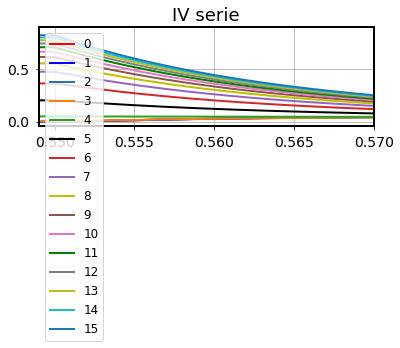

In [229]:
fig = plt.figure()
#axes_1= fig.add_subplot(111)
#plt.title('V applied')
#plt.plot(t, V, 'b-', linewidth=2.0, label="V (mV)")
#plt.legend(loc='lower right')


axes = fig.add_subplot(211)
plt.title('IV serie')

plt.plot(t, Open_states[:,0] , 'r-', linewidth=2.0, label="0")
plt.plot(t, Open_states[:,1] , 'b-', linewidth=2.0, label="1")
plt.plot(t, Open_states[:,2] , linewidth=2.0, label="2")
plt.plot(t, Open_states[:,3] , linewidth=2.0, label="3")
plt.plot(t, Open_states[:,4] , linewidth=2.0, label="4")
plt.plot(t, Open_states[:,5] , 'k-', linewidth=2.0, label="5")
plt.plot(t, Open_states[:,6] , linewidth=2.0, label="6")
plt.plot(t, Open_states[:,7] , linewidth=2.0, label="7")
plt.plot(t, Open_states[:,8] , 'y-', linewidth=2.0, label="8")
plt.plot(t, Open_states[:,9] , linewidth=2.0, label="9")
plt.plot(t, Open_states[:,10] , linewidth=2.0, label="10")
plt.plot(t, Open_states[:,11] , 'g-', linewidth=2.0, label="11")
plt.plot(t, Open_states[:,12] , linewidth=2.0, label="12")
plt.plot(t, Open_states[:,13] , linewidth=2.0, label="13")
plt.plot(t, Open_states[:,14] , linewidth=2.0, label="14")
plt.plot(t, Open_states[:,15] , linewidth=2.0, label="15")

#axes.set_ylim([-1,1])
axes.set_xlim([0.549,0.57])

plt.legend(loc='upper left')
plt.show()

In [230]:
def Boltz_eq(x,V1_2,k):
    return 1.0/(1.0 + np.exp(-(x-V1_2)/k))

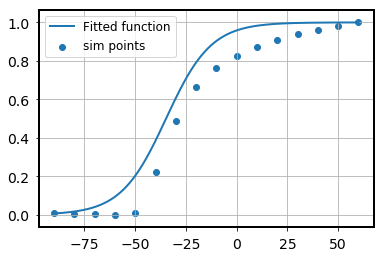

In [231]:
x0=np.linspace(-90,60,1000)
V=np.linspace(-90,60,16)

g_gmax=(max_conductance-np.amin(max_conductance))/(np.amax(max_conductance)-np.amin(max_conductance))
I_Imax = (max_currents-np.amin(max_currents))/(np.amax(max_currents)-np.amin(max_currents))
fig = plt.figure()
plt.scatter(V,g_gmax, label='sim points')
plt.plot(x0, Boltz_eq(x0, -34.80, 11.10), label='Fitted function')

plt.legend(loc='best')

plt.show()

In [232]:
params,params_cov = curve_fit(Boltz_eq,V,g_gmax)
print params
print params_cov

[-25.48972383  12.28339779]
[[ 2.30290585e+00 -3.48015521e-04]
 [-3.48015521e-04  1.78718886e+00]]


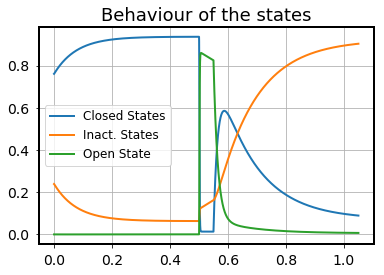

In [233]:
sum_Closed = C[:,0]+C[:,1]+C[:,2]+C[:,3]+C[:,4]
sum_Inactivated = C[:,5]+C[:,6]+C[:,7]+C[:,8]+C[:,9]

fig = plt.figure()
axes_1= fig.add_subplot(111)
plt.title('Behaviour of the states')
    
plt.plot(t, sum_Closed, linewidth=2.0, label="Closed States")
plt.plot(t, sum_Inactivated, linewidth=2.0, label="Inact. States")
plt.plot(t, C[:,10], linewidth=2.0, label="Open State")

plt.legend(loc='center left')
plt.show()

## Inactivation Model for the Mutated

In [220]:
 def ode_inac_mut (C, t, p):
    
    C0=C[0]
    C1=C[1]
    C2=C[2]
    C3=C[3]
    C4=C[4]
    I0=C[5]
    I1=C[6]
    I2=C[7]
    I3=C[8]
    I4=C[9]
    O=C[10]

    
    #constants
    
    T = 291.0 #K or 18 degree celsius
    e =  1.602176634 * (10**-19.0) # C
    K_B = 1.380649 * (10**-23.0) # J*K^-1
    
    exp_factor = (e/(K_B * T)) * (10**-3) 

    #Voltage sequences
    
    V = 0.0 #mV 

    if p[4] <= t < p[5]:
        V=p[0]
        
    if p[5] <= t < p[6]:
        V=p[1]
        
    if p[6] <= t <= p[7]:
        V=p[2]
        
    if t > p[7] :
        V=p[3]
 


    # Mutated parameters
    alpha_0 = 890.87 #s^-1
    alpha_1 = 0.302 #s^-1
    
    beta_0 = 20.32 #s^-1
    beta_1 = 1.82 #s^-1
    
    k_CO_0 = 496.15 #s^-1
    k_CO_1 = 0.38 #s^-1
    
    k_OC_0 = 39.48 #s^-1
    k_OC_1 = 0.28 #s^-1
    
    k_CI = 205.00 #s^-1
    k_IC = 0.05 #s^-1 0.20
    
    f = 0.42 # 0.31
     
    #voltage dependent rate constants
    
    alpha = alpha_0 * np.exp(alpha_1 * (V * exp_factor))
    beta = beta_0 * np.exp(-1.0 * beta_1 * (V * exp_factor))
    k_CO = k_CO_0 * np.exp(k_CO_1 * (V * exp_factor))
    k_OC = k_OC_0 * np.exp(-1.0 * k_OC_1 * (V * exp_factor))
    
    
    # ODEs
    
    dC0dt = beta * C1 + (k_IC/(f**4.0)) * I0 - (k_CI*(f**4.0) + 4.0 * alpha) * C0
    dC1dt = 4.0 * alpha * C0 + 2.0 * beta * C2 + (k_IC/(f**3.0)) * I1 - (k_CI*(f**3.0) + beta + 3.0 * alpha) * C1 
    dC2dt = 3.0 * alpha * C1 + 3.0 * beta * C3 + (k_IC/(f**2.0)) * I2 - (k_CI*(f**2.0) + 2.0 * beta + 2.0 * alpha) * C2 
    dC3dt = 2.0 * alpha * C2 + 4.0 * beta * C4 + (k_IC/f) * I3 - (k_CI*f + 3.0 * beta + 1.0 * alpha) * C3 
    dC4dt = 1.0 * alpha * C3 + k_OC * O + k_IC * I4 - (k_CI + k_CO + 4.0 * beta) * C4 
    
    dI0dt = beta * f * I1 + (k_CI*(f**4.0)) * C0 - (k_IC/(f**4.0) + 4.0 * (alpha/f)) * I0
    dI1dt = 4.0 * (alpha/f) * I0 + 2.0 * beta * f * I2 + (k_CI*(f**3.0)) * C1 - (k_IC/(f**3.0) + beta * f + 3.0 * (alpha/f)) * I1 
    dI2dt = 3.0 * (alpha/f) * I1 + 3.0 * beta * f * I3 + (k_CI*(f**2.0)) * C2 - (k_IC/(f**2.0) + 2.0 * beta * f + 2.0 * (alpha/f)) * I2 
    dI3dt = 2.0 * (alpha/f) * I2 + 4.0 * beta * f * I4 + (k_CI*f) * C3 - (k_IC/f + 3.0 * beta * f + 1.0 * (alpha/f)) * I3 
    dI4dt = 1.0 * (alpha/f) * I3 + k_CI * C4 - (k_IC + 4.0 * beta * f) * I4     
    
    dOdt = k_CO * C4 - k_OC * O
    
    return (dC0dt, dC1dt, dC2dt, dC3dt, dC4dt, dI0dt, dI1dt, dI2dt, dI3dt, dI4dt, dOdt)

In [221]:
Vhold   =  -90.0 # mV
Vstep   =  10.0 # mV
#Vtest   =  -90.0 # mV
Vrepo   =  60.0 # mV
Vmax    =  60.0 # mV

# conductance parameters

#EK      = 0.0    # mV
gK_max  = 15.9     # nS 

# Assuming no leaking
#EL      = 0.0    # mV
#gL_max  = 0.0    # mS 

# Membrane capacitance
Cm      = 1.0    # microF cm^-2

# Time of experiments
tini_eq   = 0    # s
tini_prep = 1.00 # s
tini_test = 2.00 # s
tini_repo = 3.00 # s
tend = 3.00 # s

# Time discretiztion
Npoints = 100000
Points_per_sec = np.int(Npoints/tend) 


# time array
t = np.linspace(tini_eq,tend,Npoints)

# Guess of initial conditions for the states 

C0_0=0.4390
C1_0=0.2588
C2_0=0.0572
C3_0=0.0056
C4_0=0.0002
I0_0=0.0128
I1_0=0.0553
I2_0=0.0894
I3_0=0.0642
I4_0=0.0172
O_0=0.0001

# Pack up the parameters and initial conditions:

z0 = [C0_0, C1_0, C2_0, C3_0, C4_0, I0_0, I1_0, I2_0, I3_0, I4_0, O_0]

steps = np.abs(np.int((Vhold-Vmax)/Vstep)) + 1

Open_states = np.zeros((Npoints,steps))

max_conductance = np.zeros(steps) 

max_currents = np.zeros(steps)

for i in range(0,steps):
    
    
    # Define Potential function (To be improved if one wants to do IV, deactivation, inactivation or recovery)
    Vtest = -90.0 + i * Vstep
    #V = np.zeros(Npoints)
    #V[np.int(Points_per_sec*tini_eq):np.int(Points_per_sec*tini_prep)] = Vhold
    #V[np.int(Points_per_sec*tini_prep):np.int(Points_per_sec*tini_test)] = Vtest
    #V[np.int(Points_per_sec*tini_test):np.int(Points_per_sec*tend)+1] = Vrepo

    K = [Vhold, Vtest, Vrepo, Vrepo, tini_eq, tini_prep, tini_test, tini_repo]


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Call for the ODE integrator with initial conditions z0 and parameter K
    C = odeint(ode_inac_mut, z0, t, args=(K,))

    Open_states[:,i] = C[:,10]
      
    max_conductance[i] = gK_max * np.amax(C[np.int(Points_per_sec*tini_test)+1:,10]-C[np.int(Points_per_sec*tini_test)-1,10])
    
    # Compute the current proportional to the open channel conductance and potential applied
    
    max_currents[i] = max_conductance[i] * (Vrepo - Vhold)
    
    #I = gK_max * C[:,10] * (V[:] - Vhold) # nS * mV = pA

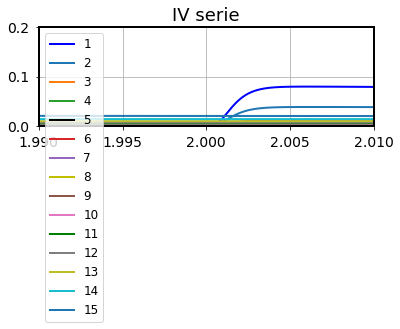

In [222]:
fig = plt.figure()
#axes_1= fig.add_subplot(111)
#plt.title('V applied')
#plt.plot(t, V, 'b-', linewidth=2.0, label="V (mV)")
#plt.legend(loc='lower right')


axes = fig.add_subplot(211)
plt.title('IV serie')

#plt.plot(t, Open_states[:,0] , 'r-', linewidth=2.0, label="0")
plt.plot(t, Open_states[:,1] , 'b-', linewidth=2.0, label="1")
plt.plot(t, Open_states[:,2] , linewidth=2.0, label="2")
plt.plot(t, Open_states[:,3] , linewidth=2.0, label="3")
plt.plot(t, Open_states[:,4] , linewidth=2.0, label="4")
plt.plot(t, Open_states[:,5] , 'k-', linewidth=2.0, label="5")
plt.plot(t, Open_states[:,6] , linewidth=2.0, label="6")
plt.plot(t, Open_states[:,7] , linewidth=2.0, label="7")
plt.plot(t, Open_states[:,8] , 'y-', linewidth=2.0, label="8")
plt.plot(t, Open_states[:,9] , linewidth=2.0, label="9")
plt.plot(t, Open_states[:,10] , linewidth=2.0, label="10")
plt.plot(t, Open_states[:,11] , 'g-', linewidth=2.0, label="11")
plt.plot(t, Open_states[:,12] , linewidth=2.0, label="12")
plt.plot(t, Open_states[:,13] , linewidth=2.0, label="13")
plt.plot(t, Open_states[:,14] , linewidth=2.0, label="14")
plt.plot(t, Open_states[:,15] , linewidth=2.0, label="15")

axes.set_ylim([0,0.2])
axes.set_xlim([1.99,2.01])

plt.legend(loc='upper left')
plt.show()

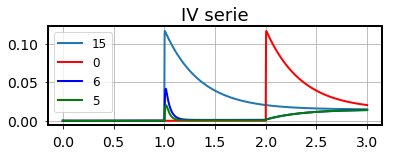

In [223]:
fig = plt.figure()
axes = fig.add_subplot(211)
plt.title('IV serie')
plt.plot(t, Open_states[:,15] , linewidth=2.0, label="15")
plt.plot(t, Open_states[:,0] , 'r-', linewidth=2.0, label="0")
plt.plot(t, Open_states[:,6] , 'b-', linewidth=2.0, label="6")
plt.plot(t, Open_states[:,5] , 'g-', linewidth=2.0, label="5")
#axes.set_ylim([-1,1])
#axes.set_xlim([1.9,2.17])

plt.legend(loc='upper left')
plt.show()

In [224]:
def Boltz_eq_in(x,V1_2,k):
    return 1.0/(1.0 + np.exp((x-V1_2)/k))

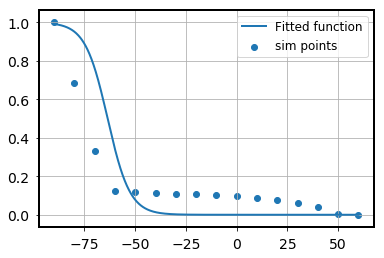

In [225]:
x0=np.linspace(-90,60,1000)
V=np.linspace(-90,60,16)

g_gmax=(max_conductance-np.amin(max_conductance))/(np.amax(max_conductance)-np.amin(max_conductance))
I_Imax = (max_currents-np.amin(max_currents))/(np.amax(max_currents)-np.amin(max_currents))
fig = plt.figure()
plt.scatter(V,g_gmax, label='sim points')
#plt.scatter(V,I_Imax, label='sim points2')
plt.plot(x0, Boltz_eq_in(x0, -63.60, 5.50), label='Fitted function')

plt.legend(loc='best')

plt.show()

In [226]:
params,params_cov = curve_fit(Boltz_eq_in,V,g_gmax)
print params
print params_cov

[-73.91931947   6.84277976]
[[ 2.64349614 -0.03964007]
 [-0.03964007  2.13348308]]


## Recovery from Inactivation model for the Mutated

In [214]:
def ode_rec_mut (C, t, p):
    
    C0=C[0]
    C1=C[1]
    C2=C[2]
    C3=C[3]
    C4=C[4]
    I0=C[5]
    I1=C[6]
    I2=C[7]
    I3=C[8]
    I4=C[9]
    O=C[10]

    
    #constants
    
    T = 291.0 #K or 18 degree celsius
    e =  1.602176634 * (10**-19.0) # C
    K_B = 1.380649 * (10**-23.0) # J*K^-1
    
    exp_factor = (e/(K_B * T)) * (10**-3) 

    #Voltage sequences
    
    V = 0.0 #mV 

    if p[5] <= t < p[6]:
        V=p[0]
        
    if p[6] <= t < p[7]:
        V=p[1]
        
    if p[7] <= t <= p[8]:
        V=p[2]
        
    if p[8] <= t <= p[9]:
        V=p[3]
 
    if t >= p[9]:
        V=p[4]

    # wild type parameters
    alpha_0 = 890.87 #s^-1
    alpha_1 = 0.302 #s^-1
    
    beta_0 = 20.32 #s^-1
    beta_1 = 1.82 #s^-1
    
    k_CO_0 = 496.15 #s^-1
    k_CO_1 = 0.38 #s^-1
    
    k_OC_0 = 39.48 #s^-1
    k_OC_1 = 0.28 #s^-1
    
    k_CI = 205.00 #s^-1
    k_IC = 0.05 #s^-1 0.20
    
    f = 0.42 # 0.31
    
    #voltage dependent rate constants
    
    alpha = alpha_0 * np.exp(alpha_1 * (V * exp_factor))
    beta = beta_0 * np.exp(-1.0 * beta_1 * (V * exp_factor))
    k_CO = k_CO_0 * np.exp(k_CO_1 * (V * exp_factor))
    k_OC = k_OC_0 * np.exp(-1.0 * k_OC_1 * (V * exp_factor))
    
    
    # ODEs
    
    dC0dt = beta * C1 + (k_IC/(f**4.0)) * I0 - (k_CI*(f**4.0) + 4.0 * alpha) * C0
    dC1dt = 4.0 * alpha * C0 + 2.0 * beta * C2 + (k_IC/(f**3.0)) * I1 - (k_CI*(f**3.0) + beta + 3.0 * alpha) * C1 
    dC2dt = 3.0 * alpha * C1 + 3.0 * beta * C3 + (k_IC/(f**2.0)) * I2 - (k_CI*(f**2.0) + 2.0 * beta + 2.0 * alpha) * C2 
    dC3dt = 2.0 * alpha * C2 + 4.0 * beta * C4 + (k_IC/f) * I3 - (k_CI*f + 3.0 * beta + 1.0 * alpha) * C3 
    dC4dt = 1.0 * alpha * C3 + k_OC * O + k_IC * I4 - (k_CI + k_CO + 4.0 * beta) * C4 
    
    dI0dt = beta * f * I1 + (k_CI*(f**4.0)) * C0 - (k_IC/(f**4.0) + 4.0 * (alpha/f)) * I0
    dI1dt = 4.0 * (alpha/f) * I0 + 2.0 * beta * f * I2 + (k_CI*(f**3.0)) * C1 - (k_IC/(f**3.0) + beta * f + 3.0 * (alpha/f)) * I1 
    dI2dt = 3.0 * (alpha/f) * I1 + 3.0 * beta * f * I3 + (k_CI*(f**2.0)) * C2 - (k_IC/(f**2.0) + 2.0 * beta * f + 2.0 * (alpha/f)) * I2 
    dI3dt = 2.0 * (alpha/f) * I2 + 4.0 * beta * f * I4 + (k_CI*f) * C3 - (k_IC/f + 3.0 * beta * f + 1.0 * (alpha/f)) * I3 
    dI4dt = 1.0 * (alpha/f) * I3 + k_CI * C4 - (k_IC + 4.0 * beta * f) * I4     
    
    dOdt = k_CO * C4 - k_OC * O
    
    return (dC0dt, dC1dt, dC2dt, dC3dt, dC4dt, dI0dt, dI1dt, dI2dt, dI3dt, dI4dt, dOdt)

In [215]:
Vhold   =  -90.0 # mV
Vpulse  =   60.0 # mV
Vinter  =  -90.0 # mV
Vrep    =   60.0 # mV
Vfin    =  -90.0 # mV

# conductance parameters

#EK      = 0.0    # mV
gK_max  = 15.9     # nS 

# Assuming no leaking
#EL      = 0.0    # mV
#gL_max  = 0.0    # mS 

# Membrane capacitance
Cm      = 1.0    # microF cm^-2

# Time of experiments
tini_eq   = 0    # s
tini_prep = 1.00 # s
tini_pulse = 2.00 # s
tini_repo = 3.00 # s
tend = 4.00 # s

pulse_interval = 0.015 # s
max_pulse_interval = 0.300 # s
min_pulse_interval = 0.015 # s

# Time discretiztion
Npoints = 100000
Points_per_sec = np.int(Npoints/tend) 


# time array
t = np.linspace(tini_eq,tend,Npoints)

# Guess of initial conditions for the states 

C0_0=0.4390
C1_0=0.2588
C2_0=0.0572
C3_0=0.0056
C4_0=0.0002
I0_0=0.0128
I1_0=0.0553
I2_0=0.0894
I3_0=0.0642
I4_0=0.0172
O_0=0.0001

# Pack up the parameters and initial conditions:

z0 = [C0_0, C1_0, C2_0, C3_0, C4_0, I0_0, I1_0, I2_0, I3_0, I4_0, O_0]

steps = np.abs(np.int((max_pulse_interval-min_pulse_interval)/pulse_interval)) + 1

Open_states = np.zeros((Npoints,steps))

max_conductance = np.zeros(steps) 

max_currents = np.zeros(steps)

for i in range(0,steps):
    
    
    # Define Potential function (To be improved if one wants to do IV, deactivation, inactivation or recovery)
    
    time_pulse = tini_pulse + pulse_interval * (i + 1)
    time_end_pulse = time_pulse + 1.00
    
    K = [Vhold, Vpulse, Vinter, Vrep, Vfin, tini_eq, tini_prep, tini_test, time_pulse, time_end_pulse]


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Call for the ODE integrator with initial conditions z0 and parameter K
    C = odeint(ode_rec_mut, z0, t, args=(K,))

    Open_states[:,i] = C[:,10]
      
    #max_conductance[i] = gK_max * np.amax(C[np.int(Points_per_sec*tini_test)+1:,10]-C[np.int(Points_per_sec*tini_test)-100,10])
    
    max_conductance[i] = gK_max * np.amax(C[np.int(Points_per_sec*time_pulse):,10])
    
    # Compute the current proportional to the open channel conductance and potential applied
    
    max_currents[i] = max_conductance[i] * (Vtest - Vhold)
    
    #I = gK_max * C[:,10] * (V[:] - Vhold) # nS * mV = pA

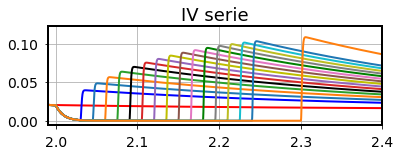

In [216]:
fig = plt.figure()
#axes_1= fig.add_subplot(111)
#plt.title('V applied')
#plt.plot(t, V, 'b-', linewidth=2.0, label="V (mV)")
#plt.legend(loc='lower right')


axes = fig.add_subplot(211)
plt.title('IV serie')

plt.plot(t, Open_states[:,0] , 'r-', linewidth=2.0, label="0")
plt.plot(t, Open_states[:,1] , 'b-', linewidth=2.0, label="1")
plt.plot(t, Open_states[:,2] , linewidth=2.0, label="2")
plt.plot(t, Open_states[:,3] , linewidth=2.0, label="3")
plt.plot(t, Open_states[:,4] , linewidth=2.0, label="4")
plt.plot(t, Open_states[:,5] , 'k-', linewidth=2.0, label="5")
plt.plot(t, Open_states[:,6] , linewidth=2.0, label="6")
plt.plot(t, Open_states[:,7] , linewidth=2.0, label="7")
plt.plot(t, Open_states[:,8] , 'y-', linewidth=2.0, label="8")
plt.plot(t, Open_states[:,9] , linewidth=2.0, label="9")
plt.plot(t, Open_states[:,10] , linewidth=2.0, label="10")
plt.plot(t, Open_states[:,11] , 'g-', linewidth=2.0, label="11")
plt.plot(t, Open_states[:,12] , linewidth=2.0, label="12")
plt.plot(t, Open_states[:,13] , linewidth=2.0, label="13")
plt.plot(t, Open_states[:,14] , linewidth=2.0, label="14")
plt.plot(t, Open_states[:,15] , linewidth=2.0, label="15")

plt.plot(t, Open_states[:,19] , linewidth=2.0, label="19")

#axes.set_ylim([0,0.2])
axes.set_xlim([1.99,2.4])

#plt.legend(loc='upper left')
plt.show()

In [217]:
def Simple_exp_eq(x,tau):
    return 1.0 - np.exp(-(x - 15.0)/ tau)

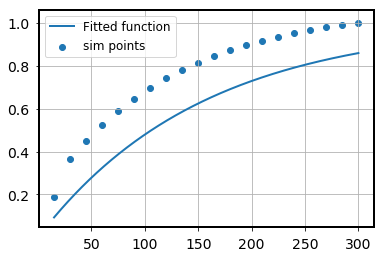

In [218]:
x0 = np.linspace(15,300,1000)
interpulses = np.linspace(15,300,20)

g_gmax=(max_conductance)/(np.amax(max_conductance))
I_Imax = (max_currents-np.amin(max_currents))/(np.amax(max_currents)-np.amin(max_currents))
fig = plt.figure()

plt.scatter(interpulses, g_gmax, label='sim points')
plt.scatter(interpulses,I_Imax, label='sim points2')

plt.plot(x0, Simple_exp_eq(x0, 153.4), label='Fitted function')

plt.legend(loc='best')

plt.show()

In [219]:
params,params_cov = curve_fit(Simple_exp_eq,interpulses,g_gmax)
print params
print params_cov

[83.52537998]
[[2.68019136]]
